In [1]:
##This is to test code snippets for the pheromoneFinder codebase
import sys
import os
from os import listdir
from os.path import isfile, join

import traceback
import re

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio import pairwise2
from collections import defaultdict
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Blast.Applications import NcbiblastxCommandline
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
import xml.etree.ElementTree as ET

#import dendropy
import numpy as np
import seaborn as sns
import pandas as pd
from pylab import *
import matplotlib.pyplot as plt

import csv
import math
import operator
import itertools
from operator import attrgetter
from pprint import pprint

data_dir = "Raw/"

In [2]:
#Printing file list
fileList = [f for f in listdir(data_dir)]
print("List of files:")
print("\n".join(fileList))

List of files:
.ipynb_checkpoints
332genomes_Shen2017.csv
332taxa_index.txt
332_2408OGs_timetree_mcmctree.nwk
332_2408OGs_timetree_reltime.nwk
distPlot_YarLip1_caax-v2-Asn_uniqueLoci_translate-pairwise-dist_200112.pdf
heatMap_YarLip1_caax-v2-Asn_uniqueLoci_pairwise-dist_191212.pdf
heatMap_YarLip1_caax-v2-Asn_uniqueLoci_translate-pairwise-dist_200112.pdf
RAxML_bipartitions.343_2408OGs_2408P
taxonGroups.csv
Yarli1_AssemblyScaffolds-put-v2p3_180508.fasta
Yarli1_AssemblyScaffolds-put-v2p3_180508_unique.fasta
YarLip1_caax-v2-Asn.fasta
YarLip1_caax-v2-Asn_unique.fasta
YarLip1_caax-v2-Asn_uniqueLoci.fasta
YarLip1_caax-v2-Asn_uniqueLoci_pairwise-dist.csv
YarLip1_caax-v2-Asn_uniqueLoci_translate-pairwise-dist.csv


In [3]:
##Testing input of sequences
##, encoding='utf-8-sig'
dictionaryFile = data_dir+"332taxa_index.txt"
with open(dictionaryFile, mode='r') as infile:
    reader = csv.reader(infile)
    fungalDictionary = {rows[0].split("\t")[0]: rows[0].split("\t")[2] for rows in reader}
    
print(len(fungalDictionary))
#print(fungalDictionary)

333


## Code to sort all CAAX-Asn candidates for unique loci
Date started 191211, 1500 IST  
This is a small code block to accept a fasta list of all the candidates I identify from a genome and then try to get a unique list for finding multiple copies of a candidate at different genome loci (obviously).
> On 191212, I realised that if my function has to be implemented in the pheromoneFinder.py codebase I have, then I need to use Python 2.7. Hence moving from my Py3 testbed to the this notebook, Py2-testbed.

In [4]:
##Importing the FASTA file, this won't be used when I add this to the python codebase for functionality. Remember to run the first two blocks for all library imports.
#inputFile = "Yarli1_AssemblyScaffolds-put-v2p3_180508.fasta"
inputFile = "YarLip1_caax-v2-Asn.fasta"
fileHandle = open(data_dir+inputFile, "r")
candidates = list(SeqIO.parse(fileHandle, "fasta"))
fileHandle.close()

print(candidates[0].id)
#print(candidates[0].id.split("||")[1].split("[")[3].split("-")[:])
print("There are %i candidates" % len(candidates))

yarlip|Yali0A_1||[forward][1][45693-45756-45768][Translate:MSNLTSHRVGVRSTPRRAISSCSVS*]
There are 738 candidates


In [5]:
##Function to parse candidates and eliminate those that share a CAAX tag (retain the largest ORF among those that share CAAX-STOP). 
##Trying the cheat version with a reversed iterator.
uniqueCandidates = []
skipCount = 0
for candidate in reversed(candidates):
    #print(candidate.id)
    if (uniqueCandidates != []):
        if (candidate.id.split("||")[0] == uniqueCandidates[-1].id.split("||")[0]) and (candidate.id.split("||")[1].split("[")[1] == uniqueCandidates[-1].id.split("||")[1].split("[")[1]):
            if candidate.id.split("||")[1].split("[")[3].split("-")[2] == uniqueCandidates[-1].id.split("||")[1].split("[")[3].split("-")[2]:
                skipCount += 1
            else:
                uniqueCandidates.append(candidate)
        else:
            uniqueCandidates.append(candidate)
    else:
        uniqueCandidates.append(candidate)

print("Skipped %i candidates" % skipCount)
uniqueCandidates.reverse()
print(len(uniqueCandidates))

##printing output.
outputHandle = open(data_dir+inputFile.split(".f")[0]+"_uniqueLoci.fasta", "w")
for candidate in uniqueCandidates:
    outputHandle.write(">"+str(candidate.id)+"\n"+str(candidate.seq)+"\n")
outputHandle.close()

Skipped 265 candidates
473


In [4]:
##Function to output the largest candidate from each locus in a candidate list. I am realizing that the major problem with my copynumber function when comparing across species
##in a phyloGroup.
def uniqueCandidateLoci(AsnCAAXFile):
    inputHandle = open(AsnCAAXFile, "r")
    candidates = list(SeqIO.parse(inputHandle, "fasta"))
    inputHandle.close()
    
    uniqueCandidates = []
    skipCount = 0
    for candidate in reversed(candidates):
        #print(candidate.id)
        if (uniqueCandidates != []):
            if (candidate.id.split("||")[0] == uniqueCandidates[-1].id.split("||")[0]) and (candidate.id.split("||")[1].split("[")[1] == uniqueCandidates[-1].id.split("||")[1].split("[")[1]):
                if candidate.id.split("||")[1].split("[")[3].split("-")[2] == uniqueCandidates[-1].id.split("||")[1].split("[")[3].split("-")[2]:
                    skipCount += 1
                else:
                    uniqueCandidates.append(candidate)
            else:
                uniqueCandidates.append(candidate)
        else:
            uniqueCandidates.append(candidate)
    
    print("Skipped %i candidates" % skipCount)
    uniqueCandidates.reverse()
    print(len(uniqueCandidates))
    
    #Checking for output directory, and making it if necessary.
    if not(os.path.isdir("./UniqueLoci")):
        os.mkdir("./UniqueLoci")
    
    ##printing output.
    outputHandle = open("./UniqueLoci/"+AsnCAAXFile.split("/")[-1]+".unique", "w")
    for candidate in uniqueCandidates:
        outputHandle.write(">"+str(candidate.id)+"\n"+str(candidate.seq)+"\n")
    outputHandle.close()

In [5]:
uniqueCandidateLoci("../../20190928_Fungi-pheromoneFinder/FinalCandidates/Asn-CAAX-Locator/yarrowia_lipolytica.fas.caax.asn")

Skipped 265 candidates
473


In [ ]:
for candidate in uniqueCandidates:
    print(candidate.id)

In [6]:
##Running an alignment and comparisson for the candidates to make sure I can find homologous sequences. 
##What is the best way to run a pair-wise alignment?
## hmmalign has the issue of needing a profile to align to. I need to figure out how to run this.

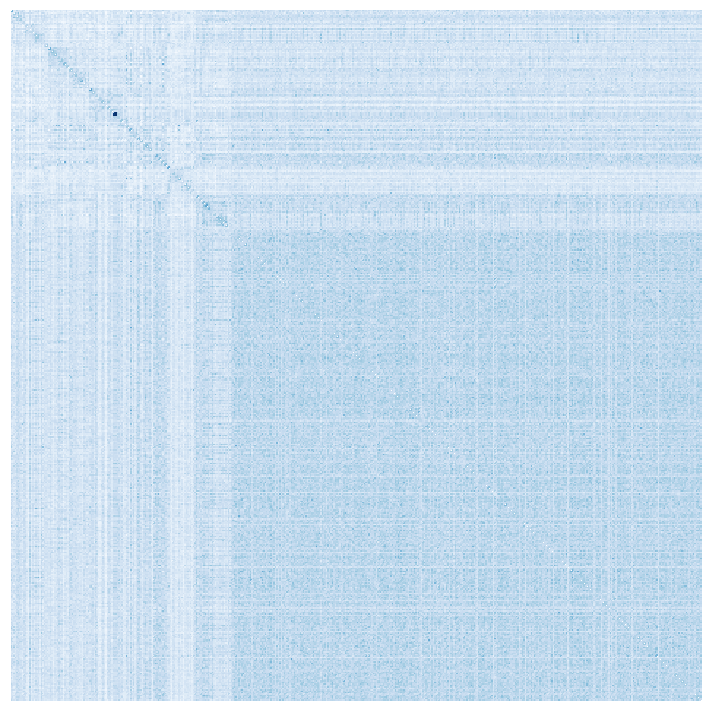

In [7]:
##I did a quick test with the most recent YarLip1 candidate list and then just imported into Geneious and ran a clustalW nucleotide by-translation alignment and got the following.
pairID = pd.read_csv(data_dir+"YarLip1_caax-v2-Asn_uniqueLoci_pairwise-dist.csv", sep=",")
#Plotting the heatmap
fig1 = figure(figsize=(10,10))
ax = sns.heatmap(pairID.iloc[:,1:].values, linewidths=0, cmap="Blues", yticklabels=False, xticklabels=False, cbar=False, square=True)
plt.yticks(rotation=0)
plt.tight_layout()

#savefig(data_dir+'/heatMap_YarLip1_caax-v2-Asn_uniqueLoci_pairwise-dist_191212.pdf', dpi=300, transparent=True)

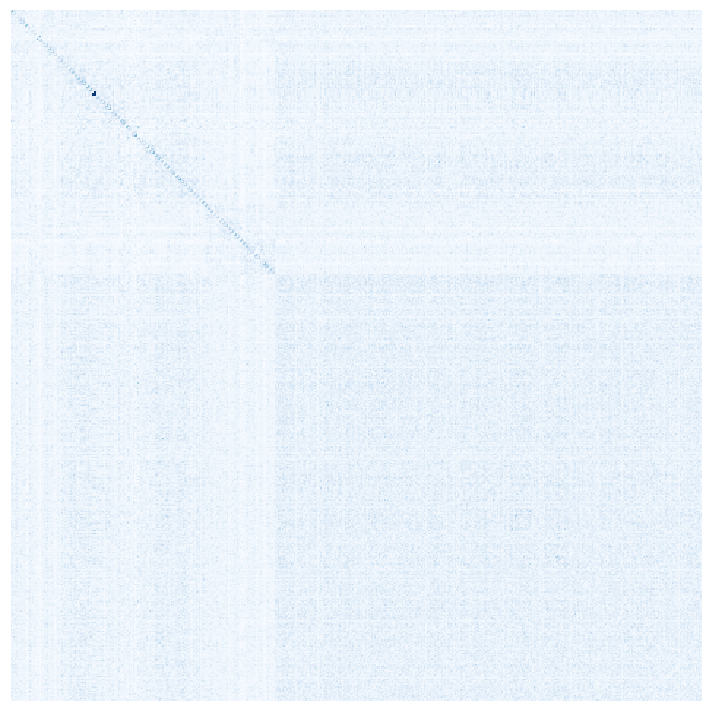

In [8]:
##I also ran an alignment on the translated products clustalw in Geneious and the results are clearer.
pairID = pd.read_csv(data_dir+"YarLip1_caax-v2-Asn_uniqueLoci_translate-pairwise-dist.csv", sep=",")
#Plotting the heatmap
fig1 = figure(figsize=(10,10))
ax = sns.heatmap(pairID.iloc[:,1:].values, linewidths=0, cmap="Blues", yticklabels=False, xticklabels=False, cbar=False, square=True)
plt.yticks(rotation=0)
plt.tight_layout()

#savefig(data_dir+'/heatMap_YarLip1_caax-v2-Asn_uniqueLoci_translate-pairwise-dist_191212.pdf', dpi=300, transparent=True)

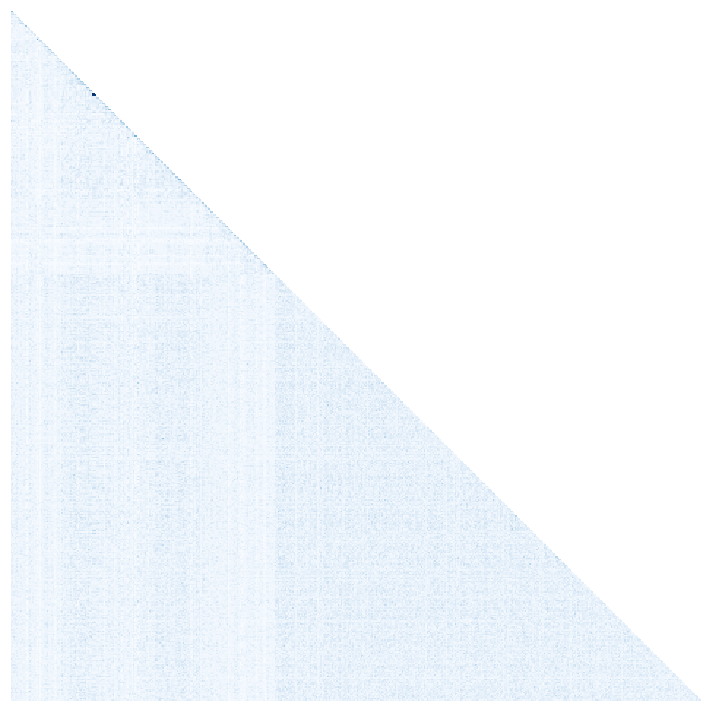

In [9]:
##I also ran an alignment on the translated products clustalw in Geneious and the results are clearer.
pairID = pd.read_csv(data_dir+"YarLip1_caax-v2-Asn_uniqueLoci_translate-pairwise-dist.csv", sep=",")
#Plotting the heatmap

mask = np.zeros_like(np.tril(pairID.iloc[:,1:].values), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig1 = figure(figsize=(10,10))
ax = sns.heatmap(np.tril(pairID.iloc[:,1:].values), mask=mask, linewidths=0, cmap="Blues", yticklabels=False, xticklabels=False, cbar=False, square=True)
plt.yticks(rotation=0)
plt.tight_layout()

#savefig(data_dir+'/heatMap_YarLip1_caax-v2-Asn_uniqueLoci_translate-pairwise-dist_200112.pdf', dpi=300, transparent=True)

In [10]:
print(pairID.columns[0])

Unnamed: 0


In [ ]:
#range(int(ceil(max(listPairID_new)))+1)

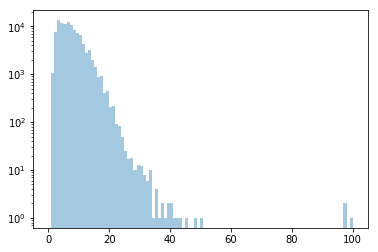

In [22]:
listPairID = np.tril(pairID.iloc[:,1:].values).flatten()
listPairID_new = listPairID[np.isfinite(listPairID)]
binPlot = range(int(ceil(max(listPairID_new)))+1)
sns.distplot(listPairID_new[np.nonzero(listPairID_new)], bins=binPlot, kde=False)
plt.yscale("log")

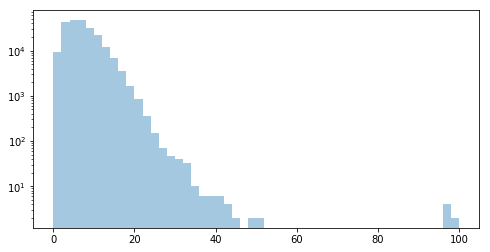

In [12]:
listPairID = pairID.melt(id_vars="Unnamed: 0")
#listPairID.tail()
fig2 = figure(figsize=(8,4))
ax2 = sns.distplot(listPairID[listPairID['value'].notna()]['value'].values, kde=False)
plt.yscale("log")

#savefig(data_dir+'/distPlot_YarLip1_caax-v2-Asn_uniqueLoci_translate-pairwise-dist_200112.pdf', dpi=300, transparent=True)

In [68]:
listPairID[listPairID['value'] > 85]

,Unnamed: 0,variable,value
26545,yarlip|Yali0F_6||[forward][1][2139263-2139362-...,yarlip|Yali0F_6||[forward][1][2134586-2134685-...,100.0
26546,yarlip|Yali0E_5||[reverse][1][1012402-1012303-...,yarlip|Yali0F_6||[forward][1][2134586-2134685-...,97.0
27017,yarlip|Yali0F_6||[forward][1][2134586-2134685-...,yarlip|Yali0F_6||[forward][1][2139263-2139362-...,100.0
27019,yarlip|Yali0E_5||[reverse][1][1012402-1012303-...,yarlip|Yali0F_6||[forward][1][2139263-2139362-...,97.0
27490,yarlip|Yali0F_6||[forward][1][2134586-2134685-...,yarlip|Yali0E_5||[reverse][1][1012402-1012303-...,97.0
27491,yarlip|Yali0F_6||[forward][1][2139263-2139362-...,yarlip|Yali0E_5||[reverse][1][1012402-1012303-...,97.0


In [67]:
print(listPairID[listPairID['value'] > 85]['Unnamed: 0'].unique())

['yarlip|Yali0F_6||[forward][1][2139263-2139362-2139374][Translate:MSKAIPRAYGTDSYRVNSNVTIVGGYRTFQPSSCVIA*]'
 'yarlip|Yali0E_5||[reverse][1][1012402-1012303-1012291][Translate:MSKAIPRDYGTDSYRVNSNVTIVGGYRTFQPSSCVIA*]'
 'yarlip|Yali0F_6||[forward][1][2134586-2134685-2134697][Translate:MSKAIPRAYGTDSYRVNSNVTIVGGYRTFQPSSCVIA*]']


In [50]:
##I am trying to implement the check of number of copies with >85% ID in uniqueLoci translated candidates. I think the easiest would be loop through the rows and 
##count the occurences of >85. Done, I am trying to plot the distribution of 
pairArray = pairID.to_numpy()
countsArray = []
for row in pairArray:
    #print(row[0])
    countsArray.append(0)
    for event in row[1:]:
        if event > 85:
            countsArray[-1] += 1
copyNumber = pd.DataFrame.from_records((zip(pairID['Unnamed: 0'].values, countsArray)), columns=["Candidate", "CopyNumber"])
#copyNumber.head()
print(copyNumber[copyNumber['CopyNumber'] != 0])

                                            Candidate  CopyNumber
56  yarlip|Yali0F_6||[forward][1][2134586-2134685-...           2
57  yarlip|Yali0F_6||[forward][1][2139263-2139362-...           2
58  yarlip|Yali0E_5||[reverse][1][1012402-1012303-...           2


## Code base to build analysis of genome files, CAAX-STOP candidates, Asn-CAAX candidates and finally "copy number" analysis of final candidates.
I need to add this as a function to pheromoneFinder.py to be run on the cluster. My hope is that I can run the functions on the folders containing the genomes, and the candidate lists.

In [6]:
##Writing the entire code as a function that I can copy straight into pheromoneFinder.
def candidateStats(genomeFolder, CAAXFolder, AsnCAAXFolder):
    #This is to check the statistics of the Asn...CAAX candidates from my algorithm.
    if (not(os.path.isdir(genomeFolder)) or not(os.path.isdir(CAAXFolder)) or not(os.path.isdir(AsnCAAXFolder))):
        print "One of the inputs provided is not a folder. Please use the folders containing the genomes (.fasta), CAAX candidates (.caax) and Asn-CAAX candidates (.asn) respectively."
    else:
        genomes = [f for f in listdir(genomeFolder) if (f.endswith(".fas") or f.endswith(".fasta") or f.endswith(".fa"))]
        #print(genomes)
        candidateCAAXList = [f[:f.rfind(".caax")] for f in listdir(CAAXFolder) if (f.endswith(".caax"))]
        #print(candidateCAAXList)
        candidateAsnCAAXList = [f[:f.rfind(".caax.asn")] for f in listdir(AsnCAAXFolder) if (f.endswith(".asn"))]
        #print(candidateAsnCAAXList)
        
        if ((set(genomes) != set(candidateCAAXList)) or (set(genomes) != set(candidateAsnCAAXList))):
            print "The files don't match up!\n"
            if (set(genomes) != set(candidateCAAXList)):
                print "There are extra CAAX-STOP candidate files:"
                extra = []
                extra = [f for f in candidateCAAXList not in genomes]
                print"\n".join(extra)
                print"\nThere are missing results for the genome files:"
                missing = []
                missing = [f for f in genomes not in candidateCAAXList]
                print "\n".join(extra)
            if (set(genomes) != set(candidateAsnCAAXList)):
                print "There are extra Asn...CAAX-STOP candidate files:"
                extra = []
                extra = [f for f in candidateAsnCAAXList not in genomes]
                print "\n".join(extra)
                print "\nThere are missing results for the genome files:"
                missing = []
                missing = [f for f in genomes not in candidateAsnCAAXList]
                print "\n".join(extra)
        else:
            genomeStats = []
            for g in genomes:
                fileHandle = open(genomeFolder+"/"+g, "r")
                scaffolds = list(SeqIO.parse(fileHandle, "fasta"))
                fileHandle.close()
                
                print "Genome file:\t\t\t\t\t", g
                print "\tScaffolds:\t\t\t\t", str(len(scaffolds))
                genomeSize = 0;
                for s in scaffolds:
                    genomeSize = genomeSize + len(s.seq);
                print "\tGenome Size:\t\t\t\t", str(genomeSize), "bp"
                
                fileHandle = open(CAAXFolder+"/"+g+".caax", "r")
                candidateCAAXs = list(SeqIO.parse(fileHandle, "fasta"))
                fileHandle.close()
                print "\tCAAX-Stop candidates:\t\t\t", str(len(candidateCAAXs))
                
                fileHandle = open(AsnCAAXFolder+"/"+g+".caax.asn", "r")
                candidateAsnCAAXs = list(SeqIO.parse(fileHandle, "fasta"))
                fileHandle.close()
                print "\tAsn...CAAX-Stop candidates:\t\t", str(len(candidateAsnCAAXs))
                
                uniqueCandidates = []
                skipCount = 0
                for candidate in reversed(candidateAsnCAAXs):
                    #print(candidate.id)
                    if (uniqueCandidates != []):
                        if (candidate.id.split("||")[0] == uniqueCandidates[-1].id.split("||")[0]) and (candidate.id.split("||")[1].split("[")[1] == uniqueCandidates[-1].id.split("||")[1].split("[")[1]):
                            if candidate.id.split("||")[1].split("[")[3].split("-")[2] == uniqueCandidates[-1].id.split("||")[1].split("[")[3].split("-")[2]:
                                skipCount += 1
                            else:
                                uniqueCandidates.append(candidate)
                        else:
                            uniqueCandidates.append(candidate)
                    else:
                        uniqueCandidates.append(candidate)
                        
                print "\tCandidates from overcounted loci:\t", skipCount
                uniqueCandidates.reverse()
                print "\tCandidates at unique loci:\t\t", str(len(uniqueCandidates)), "\n"
                
                genomeStats.append([g.split(".")[0], len(scaffolds), genomeSize, len(candidateCAAXs), len(candidateAsnCAAXs), len(uniqueCandidates)])
                
            genomeStatsFrame = pd.DataFrame.from_records(genomeStats, columns=["Species", "No. of scaffolds", "Genome Size (bp)", "No. of CAAX-Stop candidates", 
                                                                               "No. of Asn...CAAX-Stop candidates", "No. of unique locus Asn...CAAX-Stop candidates"])
            genomeStatsFrame.to_csv("genomeStats.csv", index=False)
            #I think I'm almost done!
            print "Done inspecting ", str(genomeFolder), " for ", str(len(genomes)), " genomes and their Asn...CAAX-Locator results from other input folders. Good luck!" 

In [7]:
candidateStats("../../20190928_Fungi-pheromoneFinder/CandidateStats/", "../../20190928_Fungi-pheromoneFinder/CandidateStats/", "../../20190928_Fungi-pheromoneFinder/CandidateStats/")

Genome file:					yarrowia_lipolytica.fas
	Scaffolds:				6
	Genome Size:				20502978 bp
	CAAX-Stop candidates:			1953
	Asn...CAAX-Stop candidates:		738
	Candidates from overcounted loci:	265
	Candidates at unique loci:		473 

Done inspecting  ../../20190928_Fungi-pheromoneFinder/CandidateStats/  for  1  genomes and their Asn...CAAX-Locator results from other input folders. Good luck!


## Code base to build pair-wise alignments of all Asn...CAAX-Stop candidates (based on the translations)
The hope is to use either global or local alignments to find the best alignment of every pair and use them to build a pairwise identity scoring matrix as imported from Geneious above. This will allow me to just use the code I built above.

In [3]:
##Writing the entire code as a function that I can copy straight into pheromoneFinder.
##This function version tests for pairwise alignments with the uniqueLoci candidates but since I've noticed strange behavior when only the largest candidate from each locus is
## considered, I am going to write a version below that considers all candidates.
def candidateCopyNumber(AsnCAAXFile, outputFolder):
    ##Importing the sequences in the Asn...CAAX candidate output file.
    try:
        inputHandle = open(AsnCAAXFile, "U")
    except:
        print "The Input file, ", AsnCAAXFile, " does not seem to exist. Check the input file to make sure it is the output of the AsnLocator (*.caax.asn)."
    else:
        ##Importing 
        candidatesAsnCAAX = list(SeqIO.parse(inputHandle, "fasta"))
        inputHandle.close()
        
        if (AsnCAAXFile.rfind(".caax.asn") == -1 or len(candidatesAsnCAAX) == 0):
            print "The Input file does not seem to be the Asn...CAAX file (no .caax.asn extension) or there seems to be no candidates in the file."
        else:
            print "Analyzing ", len(candidatesAsnCAAX), " Asn...CAAX candidates from ", AsnCAAXFile.split("/")[-1].split(".")[0], " for unique locus candidates that are potential gene copies."
            
            ##Identifying candidates from Unique loci since they will affect the estimation of pairwise identity.
            uniqueCandidates = []
            skipCount = 0
            for candidate in reversed(candidatesAsnCAAX):
                #print(candidate.id)
                if (uniqueCandidates != []):
                    if (candidate.id.split("||")[0] == uniqueCandidates[-1].id.split("||")[0]) and (candidate.id.split("||")[1].split("[")[1] == uniqueCandidates[-1].id.split("||")[1].split("[")[1]):
                        if candidate.id.split("||")[1].split("[")[3].split("-")[2] == uniqueCandidates[-1].id.split("||")[1].split("[")[3].split("-")[2]:
                            skipCount += 1
                        else:
                            uniqueCandidates.append(candidate)
                    else:
                        uniqueCandidates.append(candidate)
                else:
                    uniqueCandidates.append(candidate)
            print "\nCandidates from overcounted loci:\t", skipCount
            uniqueCandidates.reverse()
            print "Candidates at unique loci:\t\t", str(len(uniqueCandidates)), "\n"
            
            pairScoresList = []
            reducePairScoresList = []
            alignScores = np.zeros((len(uniqueCandidates), len(uniqueCandidates)))
            for iterator in range(len(uniqueCandidates)):
                for iterator2 in range(iterator):
                    alignScores[iterator, iterator2] = 100*pairwise2.align.globalxx(uniqueCandidates[iterator].seq.translate(), uniqueCandidates[iterator2].seq.translate(), score_only=True)/max(len(uniqueCandidates[iterator].seq.translate()), len(uniqueCandidates[iterator2].seq.translate()))
                    pairScoresList.append([uniqueCandidates[iterator].id, uniqueCandidates[iterator2].id, alignScores[iterator, iterator2]])
                    
                    if ((uniqueCandidates[iterator].id.split("||")[0] == uniqueCandidates[iterator2].id.split("||")[0]) and (re.split(r'-', re.split(r'[\[\]]', uniqueCandidates[iterator].id.split("||")[1])[5])[1] == re.split(r'-', re.split(r'[\[\]]', uniqueCandidates[iterator2].id.split("||")[1])[5])[1])):
                        print "Skipping ", uniqueCandidates[iterator].id, " and ", uniqueCandidates[iterator2].id, " they are from the same locus!"
                        reducePairScoresList.append([uniqueCandidates[iterator].id, uniqueCandidates[iterator2].id, 0])
                    else:
                        reducePairScoresList.append([uniqueCandidates[iterator].id, uniqueCandidates[iterator2].id, alignScores[iterator, iterator2]])
            #print(alignScores)
            
            pairScores = pd.DataFrame.from_records(reducePairScoresList, columns=["candidate1", "candidate2", "pairwiseScore"])
            #print(pairScores[pairScores['pairwiseScore'] > 85])
            
            listPairID = np.tril(alignScores).flatten()
            listPairID_new = listPairID[np.isfinite(listPairID)]
            binPlot = range(int(ceil(max(listPairID_new)))+1)
            sns.distplot(listPairID_new[np.nonzero(listPairID_new)], bins=binPlot, kde=False)
            plt.yscale("log")
            
            return pairScores

In [52]:
##Writing the entire code as a function that I can copy straight into pheromoneFinder.
##This function is modified to account for multiple candidates from the same STOP where one of them (and not just the largest candidate) might represent a candidate that has multiple
## copies. I've set this up by estimating pairwise scores of all candidates and then setting the score to 0 when the pair considered are candidates from the same STOP.
##I am also going to ouput the histogram of pairwise distances after correcting for candidates from the same locus and also 
def candidateCopyNumber(AsnCAAXFile):
    ##Importing the sequences in the Asn...CAAX candidate output file.
    try:
        inputHandle = open(AsnCAAXFile, "U")
    except:
        print "The Input file, ", AsnCAAXFile, " does not seem to exist. Check the input file to make sure it is the output of the AsnLocator (*.caax.asn)."
    else:
        ##Importing 
        candidatesAsnCAAX = list(SeqIO.parse(inputHandle, "fasta"))
        inputHandle.close()
        
        if (AsnCAAXFile.rfind(".caax.asn") == -1 or len(candidatesAsnCAAX) == 0):
            print "The Input file does not seem to be the Asn...CAAX file (no .caax.asn extension) or there seems to be no candidates in the file."
        else:
            print "Analyzing ", len(candidatesAsnCAAX), " Asn...CAAX candidates from ", AsnCAAXFile.split("/")[-1].split(".")[0], " for candidates that are potential gene copies."
            
            pairScoresList = []
            reducePairScoresList = []
            alignScores = np.zeros((len(candidatesAsnCAAX), len(candidatesAsnCAAX)))
            for iterator in range(len(candidatesAsnCAAX)):
                for iterator2 in range(iterator):
                    #alignScores[iterator, iterator2] = 100*pairwise2.align.globalxx(candidatesAsnCAAX[iterator].seq.translate(), candidatesAsnCAAX[iterator2].seq.translate(), score_only=True)/max(len(candidatesAsnCAAX[iterator].seq.translate()), len(candidatesAsnCAAX[iterator2].seq.translate()))
                    alignScores[iterator, iterator2] = 100*pairwise2.align.globalxx(candidatesAsnCAAX[iterator].seq.translate()[max(candidatesAsnCAAX[iterator].seq.translate()[:-10].rfind("N")-2,0):], candidatesAsnCAAX[iterator2].seq.translate()[max(candidatesAsnCAAX[iterator2].seq.translate()[:-10].rfind("N")-2,0):], score_only=True)/max(len(candidatesAsnCAAX[iterator].seq.translate()[max(candidatesAsnCAAX[iterator].seq.translate()[:-10].rfind("N")-2,0):]), len(candidatesAsnCAAX[iterator2].seq.translate()[max(candidatesAsnCAAX[iterator2].seq.translate()[:-10].rfind("N")-2,0):]))
                    #pairScoresList.append([candidatesAsnCAAX[iterator].id, candidatesAsnCAAX[iterator2].id, candidatesAsnCAAX[iterator, iterator2]])
                    
                    if ((candidatesAsnCAAX[iterator].id.split("||")[0] == candidatesAsnCAAX[iterator2].id.split("||")[0]) and (re.split(r'-', re.split(r'[\[\]]', candidatesAsnCAAX[iterator].id.split("||")[1])[5])[1] == re.split(r'-', re.split(r'[\[\]]', candidatesAsnCAAX[iterator2].id.split("||")[1])[5])[1])):
                        #print "Skipping ", candidatesAsnCAAX[iterator].id, " and ", candidatesAsnCAAX[iterator2].id, " they are from the same locus!"
                        reducePairScoresList.append([candidatesAsnCAAX[iterator].id, candidatesAsnCAAX[iterator2].id, 0])
                        alignScores[iterator, iterator2] = 0
                    else:
                        reducePairScoresList.append([candidatesAsnCAAX[iterator].id, candidatesAsnCAAX[iterator2].id, alignScores[iterator, iterator2]])
            #print(alignScores)
            
            pairScores = pd.DataFrame.from_records(reducePairScoresList, columns=["candidate1", "candidate2", "pairwiseScore"])
            #print(pairScores[pairScores['pairwiseScore'] > 85])
            
            #Checking for output directory, and making it if necessary.
            if not(os.path.isdir("./CopyNumber")):
                os.mkdir("./CopyNumber")
            
            ##Plotting the histogram of pairwise scores.
            listPairID = np.tril(alignScores).flatten()
            listPairID_new = listPairID[np.isfinite(listPairID)]
            binPlot = range(int(ceil(max(listPairID_new)))+1)
            fig = figure(figsize=(8,5))
            ax = sns.distplot(pairScores['pairwiseScore'], bins=binPlot, kde=False, hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1, "color": "black"})
            ax.axvspan(85, 100, alpha=0.3, color='red')
            plt.ylabel("Counts")
            plt.yscale("log")
            plt.tight_layout()
            savefig("./CopyNumber/"+AsnCAAXFile.split("/")[-1].split(".")[0]+"_pairID-hist.pdf", dpi=300, transparent=True)
            
            #Output the names of the candidates that have a copy among other candidates (as judged by >85% match in an alignment).
            copyNumList = list(set(list(itertools.chain(pairScores[pairScores['pairwiseScore'] > 85].candidate1.unique(), pairScores[pairScores['pairwiseScore'] > 85].candidate2.unique()))))
            outputFile = "./CopyNumber/"+AsnCAAXFile.split("/")[-1]+".multicopy"
            outputHandle = open(outputFile, "w")
            for element in copyNumList:
                for record in candidatesAsnCAAX:
                    if (record.id == element):
                        outputHandle.write(">"+str(element)+"\n"+str(record.seq)+"\n")
            outputHandle.close()
            
            print "Done processing ", len(candidatesAsnCAAX), " candidates from ", AsnCAAXFile.split("/")[-1].split(".")[0], ". Good luck!\n"
            #return pairScores

Analyzing  627  Asn...CAAX candidates from  yarrowia_deformans  for candidates that are potential gene copies.
Done processing  627  candidates from  yarrowia_deformans . Good luck!



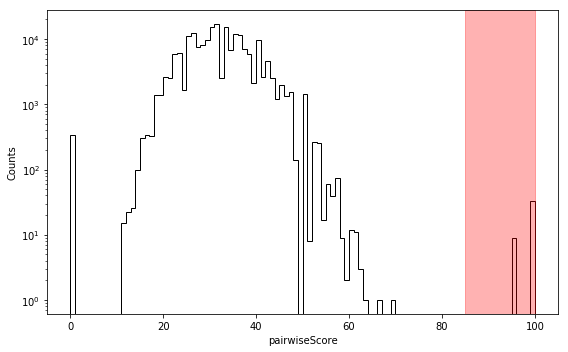

In [55]:
testingExp = candidateCopyNumber("../../20190928_Fungi-pheromoneFinder/Asn-CAAX-Locator/yarrowia_deformans.fas.caax.asn")

In [31]:
testingExp[testingExp['pairwiseScore'] > 90]

,candidate1,candidate2,pairwiseScore
14697,yarrowia_deformans|/|gi|1002317485|dbj|BCIW010...,yarrowia_deformans|/|gi|1002317485|dbj|BCIW010...,97.297297
21483,yarrowia_deformans|/|gi|1002317485|dbj|BCIW010...,yarrowia_deformans|/|gi|1002317485|dbj|BCIW010...,97.297297
21492,yarrowia_deformans|/|gi|1002317485|dbj|BCIW010...,yarrowia_deformans|/|gi|1002317485|dbj|BCIW010...,97.297297
58132,yarrowia_deformans|/|gi|1002317481|dbj|BCIW010...,yarrowia_deformans|/|gi|1002317485|dbj|BCIW010...,97.297297
58141,yarrowia_deformans|/|gi|1002317481|dbj|BCIW010...,yarrowia_deformans|/|gi|1002317485|dbj|BCIW010...,97.297297
58177,yarrowia_deformans|/|gi|1002317481|dbj|BCIW010...,yarrowia_deformans|/|gi|1002317485|dbj|BCIW010...,100.000000
81165,yarrowia_deformans|/|gi|1002317479|dbj|BCIW010...,yarrowia_deformans|/|gi|1002317485|dbj|BCIW010...,97.297297
81174,yarrowia_deformans|/|gi|1002317479|dbj|BCIW010...,yarrowia_deformans|/|gi|1002317485|dbj|BCIW010...,100.000000
81210,yarrowia_deformans|/|gi|1002317479|dbj|BCIW010...,yarrowia_deformans|/|gi|1002317485|dbj|BCIW010...,97.297297
81344,yarrowia_deformans|/|gi|1002317479|dbj|BCIW010...,yarrowia_deformans|/|gi|1002317481|dbj|BCIW010...,97.297297


In [42]:
copyNumList = list(set(list(itertools.chain(testingExp[testingExp['pairwiseScore'] > 85].candidate1.unique(), testingExp[testingExp['pairwiseScore'] > 85].candidate2.unique()))))
print(len(copyNumList))
print(copyNumList)

9
['yarrowia_deformans|/|gi|1002317479|dbj|BCIW01000010.1|||[forward][1][912729-912825-912837][Translate:MSVVKREYGNESYRVNSNVTIVGGYRTYQPSSCVIA*]', 'yarrowia_deformans|/|gi|1002317485|dbj|BCIW01000004.1|||[reverse][1][144986-144890-144878][Translate:MSVVKREYGNDSYRVNSNVTIVGGYRTYQPSSCVIA*]', 'yarrowia_deformans|/|gi|1002317485|dbj|BCIW01000004.1|||[forward][1][360113-360209-360221][Translate:MSVVKREYGNQSYRVNSNVTIVGGYRTYQPSSCVIA*]', 'yarrowia_deformans|/|gi|1002317485|dbj|BCIW01000004.1|||[forward][1][511956-512052-512064][Translate:MSVVKREYGNESYRVNSNVTIVGGYRTYQPSSCVIA*]', 'yarrowia_deformans|/|gi|1002317481|dbj|BCIW01000008.1|||[reverse][1][69294-69198-69186][Translate:MSVVKREYGNDSYRVNSNVTIVGGYRTYQPSSCVIA*]', 'yarrowia_deformans|/|gi|1002317461|dbj|BCIW01000028.1|||[reverse][1][2665-2593-2581][Translate:MKHTHGSSSKNAALCSEEACDWSKCLSS*]', 'yarrowia_deformans|/|gi|1002317476|dbj|BCIW01000013.1|||[reverse][1][569522-569426-569414][Translate:MSVVKREYGNESYRVNSNVTIVGGYRTYQPSSCIIA*]', 'yarrowia_def

In [40]:
print(testingExp[testingExp['pairwiseScore'] > 90]['candidate1'].unique())
print(testingExp[testingExp['pairwiseScore'] > 90]['candidate2'].unique())

['yarrowia_deformans|/|gi|1002317485|dbj|BCIW01000004.1|||[forward][1][511956-512052-512064][Translate:MSVVKREYGNESYRVNSNVTIVGGYRTYQPSSCVIA*]'
 'yarrowia_deformans|/|gi|1002317485|dbj|BCIW01000004.1|||[reverse][1][144986-144890-144878][Translate:MSVVKREYGNDSYRVNSNVTIVGGYRTYQPSSCVIA*]'
 'yarrowia_deformans|/|gi|1002317481|dbj|BCIW01000008.1|||[reverse][1][69294-69198-69186][Translate:MSVVKREYGNDSYRVNSNVTIVGGYRTYQPSSCVIA*]'
 'yarrowia_deformans|/|gi|1002317479|dbj|BCIW01000010.1|||[forward][1][912729-912825-912837][Translate:MSVVKREYGNESYRVNSNVTIVGGYRTYQPSSCVIA*]'
 'yarrowia_deformans|/|gi|1002317476|dbj|BCIW01000013.1|||[reverse][1][569522-569426-569414][Translate:MSVVKREYGNESYRVNSNVTIVGGYRTYQPSSCIIA*]'
 'yarrowia_deformans|/|gi|1002317472|dbj|BCIW01000017.1|||[forward][1][66539-66635-66647][Translate:MSVVKREYGNDSYRVNSNVTIVGGYRTYQPSSCVIA*]'
 'yarrowia_deformans|/|gi|1002317461|dbj|BCIW01000028.1|||[reverse][1][2665-2593-2581][Translate:MKHTHGSSSKNAALCSEEACDWSKCLSS*]']
['yarrowia_deforma

> [[200127 1500hrs]] This finally worked! I can now use a direct alignment of strings that scores matches as +1 and mismatches as 0. I run this on the translation of candidates and it matches up exactly what I hoped as long as I scale the alignment score by the length of the longer candidate (representing the fraction as a percentage).

### Code-base to concatenate files from an input list
This code is being written to pool the Asn...CAAX-Stop candidates of Phylo grouped species (divergence time horizon of 240.0 units) and run the copy number script on them. See pheromoneFinder_py3-testbed for the identification of phylogroups.

In [10]:
###Code to be written as a function since this is going to be added to my pheromoneFinder script.
##Function to concatenate Asn...CAAX-Stop candidates that are judged to be within a phylogenetic group where pheromones are expected to be conserved.
def phyloGroupCandidates(listFile, AsnCAAXFolder):
    ##The following is to read the listFile for the species candidates that I need to pool as a Phylo Group.
    with open(listFile, "r") as inputHandle:
        speciesFileList = []
        #print inputHandle.readline()
        speciesFileList = inputHandle.read().split("\n")
        
    speciesFileList.remove("")

    print speciesFileList, "\n which contains ", len(speciesFileList), " species!\n"
    phyloGroupCandidates = []
    for speciesFile in speciesFileList:
        inputHandle = open(AsnCAAXFolder+str(speciesFile), "r")
        records = list(SeqIO.parse(inputHandle, "fasta"))
        inputHandle.close()
        
        ##Extending master list.
        phyloGroupCandidates.extend(records)
    
    print len(phyloGroupCandidates)
    
    ##Making Output directory.
    if not(os.path.isdir("PhyloGroup_Asn-CAAX-Candidates")):
        os.mkdir("PhyloGroup_Asn-CAAX-Candidates")
    
    outputFile = "PhyloGroup_Asn-CAAX-Candidates/"+listFile.split("/")[-1].split(".")[0]+".fas.caax.asn"
    outputHandle = open(outputFile, "w")
    for candidate in phyloGroupCandidates:
        outputHandle.write(">"+str(candidate.id)+"\n"+str(candidate.seq)+"\n")
    outputHandle.close()

In [11]:
phyloGroupCandidates("../../20190928_Fungi-pheromoneFinder/PhyloGrouping/PhyloGroups/phyloGroup_1.txt", "../../20190928_Fungi-pheromoneFinder/Asn-CAAX-Locator/")

['yHMPu5000041678_debaryomyces_prosopidis_160928.fas.caax.asn', 'yHMPu5000041829_debaryomyces_fabryi_160928.fas.caax.asn', 'yHMPu5000041824_debaryomyces_subglobosus_160928.fas.caax.asn', 'debaryomyces_hansenii.fas.caax.asn', 'yHMPu5000041693_debaryomyces_nepalensis_160928.fas.caax.asn', 'yHMPu5000041713_debaryomyces_maramus_160928.fas.caax.asn', 'millerozyma_acaciae.fas.caax.asn', 'yHMPu5000035296_priceomyces_carsonii_160928.fas.caax.asn', 'yHMPu5000035297_priceomyces_castillae_160928.fas.caax.asn', 'priceomyces_haplophilus.fas.caax.asn', 'yHMPu5000034606_priceomyces_medius_160519.fas.caax.asn', 'scheffersomyces_lignosus.fas.caax.asn', 'scheffersomyces_stipitis.fas.caax.asn', 'spathaspora_passalidarum.fas.caax.asn', 'spathaspora_girioi.fas.caax.asn', 'spathaspora_arborariae.fas.caax.asn', 'spathaspora_gorwiae.fas.caax.asn', 'spathaspora_hagerdaliae.fas.caax.asn', 'candida_sojae.fas.caax.asn', 'candida_tropicalis.fas.caax.asn', 'candida_albicans.fas.caax.asn', 'candida_dubliniensis.fas.

## Testing random snippets of code

In [16]:
f = "test.fasta.caax"
print(f[:f.rfind(".caax")])
print(f.rfind(".caax.asn"))

test.fasta
-1


In [36]:
string = "yarrowia_deformans|/|gi|1002317485|dbj|BCIW01000004.1|||[forward][1][511956-512052-512064][Translate:MSVVKREYGNESYRVNSNVTIVGGYRTYQPSSCVIA*]"
string1 = string.split("||")[1]
string2 = re.split(r'[\[\]]', string1)
print(re.split(r'-', re.split(r'[\[\]]', string.split("||")[1])[5])[1])

512052


In [11]:
sampleString = "iterationtesting"
print(sampleString[:-4].rfind("t"))
print(sampleString[sampleString[:-4].rfind("t")-2:-4])

9
ontes


In [51]:
inputHandle = open("../../20190928_Fungi-pheromoneFinder/Asn-CAAX-Locator/saccharomyces_cerevisiae.fas.caax.asn", "U")
candidatesAsnCAAX = list(SeqIO.parse(inputHandle, "fasta"))
inputHandle.close()
iterator = 0
iterator2 = 1
print(candidatesAsnCAAX[0].seq.translate()[:-1])
print(max(len(candidatesAsnCAAX[0].seq.translate()[candidatesAsnCAAX[0].seq.translate()[:-10].rfind("N")-2:-10]), len(candidatesAsnCAAX[1].seq.translate()[candidatesAsnCAAX[1].seq.translate()[:-10].rfind("N")-2:-10])))
print(100*pairwise2.align.globalxx(candidatesAsnCAAX[iterator].seq.translate()[max(candidatesAsnCAAX[iterator].seq.translate()[:-10].rfind("N")-2,0):-10], candidatesAsnCAAX[iterator2].seq.translate()[max(candidatesAsnCAAX[iterator2].seq.translate()[:-10].rfind("N")-2,0):-10], score_only=True)/max(len(candidatesAsnCAAX[iterator].seq.translate()[max(candidatesAsnCAAX[iterator].seq.translate()[:-10].rfind("N")-2,0):-10]), len(candidatesAsnCAAX[iterator2].seq.translate()[max(candidatesAsnCAAX[iterator2].seq.translate()[:-10].rfind("N")-2,0):-10])))

alignScores = np.zeros((len(candidatesAsnCAAX), len(candidatesAsnCAAX)))
for iterator in range(len(candidatesAsnCAAX)):
    for iterator2 in range(iterator):
        #print(iterator, iterator2)
        #alignScores[iterator, iterator2] = 100*pairwise2.align.globalxx(candidatesAsnCAAX[iterator].seq.translate(), candidatesAsnCAAX[iterator2].seq.translate(), score_only=True)/max(len(candidatesAsnCAAX[iterator].seq.translate()), len(candidatesAsnCAAX[iterator2].seq.translate()))
        alignScores[iterator, iterator2] = 100*pairwise2.align.globalxx(candidatesAsnCAAX[iterator].seq.translate()[max(candidatesAsnCAAX[iterator].seq.translate()[:-10].rfind("N")-2,0):], candidatesAsnCAAX[iterator2].seq.translate()[max(candidatesAsnCAAX[iterator2].seq.translate()[:-10].rfind("N")-2,0):], score_only=True)/max(len(candidatesAsnCAAX[iterator].seq.translate()[max(candidatesAsnCAAX[iterator].seq.translate()[:-10].rfind("N")-2,0):]), len(candidatesAsnCAAX[iterator2].seq.translate()[max(candidatesAsnCAAX[iterator2].seq.translate()[:-10].rfind("N")-2,0):]))

print(alignScores)

MHQTPFLRAKHRCNCSALLPNYELCIIS
8
25.0
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [ 38.88888889   0.           0.         ...   0.           0.
    0.        ]
 [ 30.76923077  26.92307692   0.         ...   0.           0.
    0.        ]
 ...
 [ 26.92307692  23.07692308  42.30769231 ...   0.           0.
    0.        ]
 [ 26.92307692  23.07692308  42.30769231 ... 100.           0.
    0.        ]
 [ 38.88888889  46.66666667  26.92307692 ...  26.92307692  26.92307692
    0.        ]]


In [46]:
print(iterator)
print(candidatesAsnCAAX[50].seq.translate()[:-10].rfind("N"))

50
1
